<h1>Flu Shot Learning: Predict H1N1 and Seasonal Flu Vaccines</h1>

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pf
%matplotlib inline

## Load data

In [2]:
train = pd.read_csv('./training_set_features.csv', index_col='respondent_id')

In [3]:
test = pd.read_csv('./test_set_features.csv', index_col='respondent_id')

In [4]:
labels = pd.read_csv('./training_set_labels.csv', index_col='respondent_id')

### Imputation strategy

In [5]:
num_cols = train.select_dtypes('number').columns

In [6]:
cat_cols = ['race', 'sex', 
       'marital_status', 'rent_or_own',  'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation']

In [7]:
ord_cols = ['age_group', 'education',  'income_poverty',
        'employment_status']

In [8]:
assert len(num_cols)+len(cat_cols)+len(ord_cols) == train.shape[1]

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from category_encoders import OrdinalEncoder as oe
from catboost import CatBoostClassifier
from catboost import Pool, cv
from sklearn.metrics import roc_curve, roc_auc_score
import optuna

#### Impute train

In [11]:
# Categorical columns None
for col in (cat_cols+ord_cols):
    train[col] = train[col].fillna(value='None')

In [12]:
for col in num_cols:
    train[col] = train[col].fillna(value=-1)

#### Impute test

In [15]:
# Categorical columns None
for col in (cat_cols+ord_cols):
    test[col] = test[col].fillna(value='None')

In [16]:
for col in num_cols:
    test[col] = test[col].fillna(value=-1)

### Train test split

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split( train, labels, test_size=0.3, random_state=68)

In [20]:
# Get the index number of categorical features
categorical_features_indices = np.where(X_train.dtypes != float)[0]

### Optimize with Optuna and cross validation

Using just the selected features idetified in the previous notebook, led to poor perfomances; it seems to be better to use all the columns. CatBoost can easily deal with useless features not using them. 

In [21]:
train_dataset = Pool(data=X_train,
                     label=y_train.h1n1_vaccine,
                     cat_features = categorical_features_indices)

In [22]:
def objective(trial):
    param = {
        'iterations':trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
        'random_strength':trial.suggest_int("random_strength", 1,10),
        'bagging_temperature':trial.suggest_int("bagging_temperature", 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf':trial.suggest_int("min_data_in_leaf", 1,10),
        'od_type' : "Iter",
        'od_wait' : 100,
        "depth": trial.suggest_int("max_depth", 2,10),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
         'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        "loss_function": "Logloss",
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        }

    scores = cv(train_dataset,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=False, verbose=False)

    return scores['test-AUC-mean'].max()

Even though CatBoost is quite fast and I used early stopping, it's going to run 100 fits so it takes a lot of time. You can avoid re-running the optimisation and copy the parameters from the print report replacing `**trial.params` when calling CatBoost

In [23]:
sampler = optuna.samplers.TPESampler(seed=68)  # Make the sampler behave in a deterministic way.
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2021-02-17 01:10:29,502] A new study created in memory with name: no-name-6d494258-5754-40be-85bc-9ad0ddf11f82
[I 2021-02-17 01:10:56,712] Trial 0 finished with value: 0.8637121084738049 and parameters: {'iterations': 300, 'learning_rate': 0.013964954297408176, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 21.328495943450676, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8637121084738049.
[I 2021-02-17 01:11:09,451] Trial 1 finished with value: 0.8638461530457093 and parameters: {'iterations': 1200, 'learning_rate': 0.11477165079768124, 'random_strength': 9, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 7, 'l2_leaf_reg': 0.5714362138520529, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8638461530457093.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:11:31,776] Trial 2 finished with value: 0.8639277452137699 and parameters: {'iterations': 1500, 'learning_rate': 0.06018181691194878, 'random_strength': 6, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 4, 'l2_leaf_reg': 7.937278880272323e-06, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8639277452137699.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:11:41,329] Trial 3 finished with value: 0.8608185752295553 and parameters: {'iterations': 100, 'learning_rate': 0.04917655399574397, 'random_strength': 1, 'bagging_temperature': 5, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 6, 'l2_leaf_reg': 1.253388039132331e-06, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.8639277452137699.
[I 2021-02-17 01:11:50,036] Trial 4 finished with value: 0.862663502918525 and parameters: {'iterations': 1500, 'learning_rate': 0.20567786125414012, 'random_strength': 8, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 2, 'l2_leaf_reg': 0.0011659140576640084, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.8639277452137699.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:11:55,142] Trial 5 finished with value: 0.8599896908158534 and parameters: {'iterations': 100, 'learning_rate': 0.21103536986772822, 'random_strength': 4, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 4, 'l2_leaf_reg': 1.5248267732768012e-08, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.8639277452137699.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:12:21,311] Trial 6 finished with value: 0.8630183917790957 and parameters: {'iterations': 1000, 'learning_rate': 0.039222305770230614, 'random_strength': 5, 'bagging_temperature': 3, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 4, 'l2_leaf_reg': 3.544948380552023e-06, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8639277452137699.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:12:52,729] Trial 7 finished with value: 0.8620990008631028 and parameters: {'iterations': 1000, 'learning_rate': 0.045869610193466345, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 5, 'l2_leaf_reg': 6.629274905463984e-06, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8639277452137699.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:12:57,383] Trial 8 finished with value: 0.8514819320769826 and parameters: {'iterations': 1500, 'learning_rate': 0.2775338323862574, 'random_strength': 6, 'bagging_temperature': 4, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 9, 'l2_leaf_reg': 0.0010943835695463693, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.8639277452137699.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:13:01,061] Trial 9 finished with value: 0.8591475043535439 and parameters: {'iterations': 1000, 'learning_rate': 0.16527427195333977, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 5.547808519611033e-05, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.8639277452137699.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:13:13,900] Trial 10 finished with value: 0.86312465124197 and parameters: {'iterations': 500, 'learning_rate': 0.10255531532633722, 'random_strength': 3, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 1.2457134741928232e-08, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8639277452137699.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:13:31,547] Trial 11 finished with value: 0.8616743981860878 and parameters: {'iterations': 1200, 'learning_rate': 0.11052261047321708, 'random_strength': 10, 'bagging_temperature': 1, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 5, 'max_depth': 8, 'l2_leaf_reg': 1.5237074558155712, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8639277452137699.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:13:49,317] Trial 12 finished with value: 0.8627903938137103 and parameters: {'iterations': 200, 'learning_rate': 0.09690271753319116, 'random_strength': 7, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 7, 'l2_leaf_reg': 0.12547937691306765, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8639277452137699.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:13:59,621] Trial 13 finished with value: 0.85896048235637 and parameters: {'iterations': 1200, 'learning_rate': 0.1457224504434956, 'random_strength': 10, 'bagging_temperature': 2, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 10, 'l2_leaf_reg': 0.038036172848702254, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8639277452137699.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:14:37,845] Trial 14 finished with value: 0.8677815245165366 and parameters: {'iterations': 1500, 'learning_rate': 0.07546864165714305, 'random_strength': 8, 'bagging_temperature': 6, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 72.18032173984822, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:16:03,842] Trial 15 finished with value: 0.8634974959527698 and parameters: {'iterations': 1500, 'learning_rate': 0.011350538270844507, 'random_strength': 7, 'bagging_temperature': 5, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 3, 'l2_leaf_reg': 1.7957419364299216e-07, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 14 with value: 0.8677815245165366.
[I 2021-02-17 01:16:41,131] Trial 16 finished with value: 0.8669783181926874 and parameters: {'iterations': 1500, 'learning_rate': 0.07114368764050794, 'random_strength': 5, 'bagging_temperature': 7, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 8, 'l2_leaf_reg': 59.30204606639954, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:17:13,681] Trial 17 finished with value: 0.8658613573184872 and parameters: {'iterations': 1500, 'learning_rate': 0.07916430077690408, 'random_strength': 3, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 10, 'l2_leaf_reg': 43.272305097041944, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:17:26,100] Trial 18 finished with value: 0.865327007791503 and parameters: {'iterations': 1500, 'learning_rate': 0.1444241922111979, 'random_strength': 5, 'bagging_temperature': 10, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 8, 'l2_leaf_reg': 7.251031771279269, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:17:53,798] Trial 19 finished with value: 0.8568209709960097 and parameters: {'iterations': 200, 'learning_rate': 0.014674758092745856, 'random_strength': 8, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 8, 'l2_leaf_reg': 84.11021785041464, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.
[I 2021-02-17 01:18:07,950] Trial 20 finished with value: 0.8552130418981457 and parameters: {'iterations': 300, 'learning_rate': 0.07383261224712181, 'random_strength': 4, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 9, 'l2_leaf_reg': 0.010192014938373961, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:18:45,197] Trial 21 finished with value: 0.8660425278086379 and parameters: {'iterations': 1500, 'learning_rate': 0.07876046202849701, 'random_strength': 3, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 10, 'l2_leaf_reg': 66.09221125080096, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:18:56,901] Trial 22 finished with value: 0.8612015207041264 and parameters: {'iterations': 1500, 'learning_rate': 0.12711633459157837, 'random_strength': 3, 'bagging_temperature': 9, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 9, 'l2_leaf_reg': 3.402512143664688, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:19:18,772] Trial 23 finished with value: 0.8659444313076863 and parameters: {'iterations': 500, 'learning_rate': 0.07656572504789284, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 7, 'l2_leaf_reg': 49.973740114421126, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:19:50,888] Trial 24 finished with value: 0.8586495002556218 and parameters: {'iterations': 1500, 'learning_rate': 0.03245113001722131, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 10, 'l2_leaf_reg': 0.24307125645822508, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:19:58,340] Trial 25 finished with value: 0.865411807281529 and parameters: {'iterations': 1500, 'learning_rate': 0.17650748421269213, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 6, 'l2_leaf_reg': 9.654947043651513, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:20:13,053] Trial 26 finished with value: 0.8631789938825676 and parameters: {'iterations': 1500, 'learning_rate': 0.08906730961663088, 'random_strength': 2, 'bagging_temperature': 7, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 8, 'l2_leaf_reg': 1.540660461935242, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:20:33,407] Trial 27 finished with value: 0.8645055104418322 and parameters: {'iterations': 1500, 'learning_rate': 0.1307998015265274, 'random_strength': 7, 'bagging_temperature': 6, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 9, 'l2_leaf_reg': 61.61099781108686, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:20:54,039] Trial 28 finished with value: 0.8604788740772078 and parameters: {'iterations': 200, 'learning_rate': 0.02883948957336234, 'random_strength': 6, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 7, 'l2_leaf_reg': 99.11999661303703, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 14 with value: 0.8677815245165366.
[I 2021-02-17 01:21:18,084] Trial 29 finished with value: 0.8678425816294796 and parameters: {'iterations': 300, 'learning_rate': 0.06497113989042527, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 6, 'l2_leaf_reg': 14.608689376691892, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:21:36,338] Trial 30 finished with value: 0.866345342440848 and parameters: {'iterations': 300, 'learning_rate': 0.05721513400326056, 'random_strength': 8, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 6, 'l2_leaf_reg': 11.867862081465056, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:21:54,677] Trial 31 finished with value: 0.8666377100088573 and parameters: {'iterations': 300, 'learning_rate': 0.06044247755774006, 'random_strength': 8, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 6, 'l2_leaf_reg': 15.041539218385608, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:22:14,735] Trial 32 finished with value: 0.8396449797115549 and parameters: {'iterations': 300, 'learning_rate': 0.001

Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:23:12,340] Trial 35 finished with value: 0.859091682907307 and parameters: {'iterations': 300, 'learning_rate': 0.01922536188539828, 'random_strength': 8, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 0.01110740126745361, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:23:31,336] Trial 36 finished with value: 0.863158373108166 and parameters: {'iterations': 300, 'learning_rate': 0.055530577898201136, 'random_strength': 9, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 7, 'l2_leaf_reg': 0.2999542912425356, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:23:40,244] Trial 37 finished with value: 0.860102292586526 and parameters: {'iterations': 100, 'learning_rate': 0.09819662809204062, 'random_strength': 10, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 16.96570606441989, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:24:11,155] Trial 38 finished with value: 0.8613987943400353 and parameters: {'iterations': 300, 'learning_rate': 0.04351625872521103, 'random_strength': 6, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 7, 'l2_leaf_reg': 0.050190944316327105, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:24:15,230] Trial 39 finished with value: 0.8626228201741094 and parameters: {'iterations': 100, 'learning_rate': 0.2874658409563674, 'random_strength': 8, 'bagging_temperature': 5, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 4, 'l2_leaf_reg': 2.0117436612164323, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:24:47,028] Trial 40 finished with value: 0.8664808857607789 and parameters: {'iterations': 500, 'learning_rate': 0.057808600250280534, 'random_strength': 2, 'bagging_temperature': 3, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 8, 'l2_leaf_reg': 32.05231185945637, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:25:05,048] Trial 41 finished with value: 0.8669707847344054 and parameters: {'iterations': 300, 'learning_rate': 0.06575788966724784, 'random_strength': 9, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 5, 'l2_leaf_reg': 12.612382300234481, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:25:15,519] Trial 42 finished with value: 0.8559329123945962 and parameters: {'iterations': 300, 'learning_rate': 0.08646516140561726, 'random_strength': 9, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 6.224141167211693e-05, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:25:32,205] Trial 43 finished with value: 0.8657036872924841 and parameters: {'iterations': 300, 'learning_rate': 0.06574071488565231, 'random_strength': 7, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 5, 'l2_leaf_reg': 4.991483373522689, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:26:13,627] Trial 44 finished with value: 0.8662470254221912 and parameters: {'iterations': 1000, 'learning_rate': 0.040159802373041564, 'random_strength': 10, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 4, 'l2_leaf_reg': 27.169675005679508, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:26:24,899] Trial 45 finished with value: 0.8656305113146493 and parameters: {'iterations': 300, 'learning_rate': 0.10749441242004769, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.8618436335502659, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:28:15,851] Trial 46 finished with value: 0.8531606281496948 and parameters: {'iterations': 1200, 'learning_rate': 0.0016337710519915005, 'random_strength': 8, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 6, 'l2_leaf_reg': 16.87497059013893, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:28:33,565] Trial 47 finished with value: 0.8575190730336326 and parameters: {'iterations': 300, 'learning_rate': 0.026849174892958155, 'random_strength': 9, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 4, 'l2_leaf_reg': 4.7861759394234475, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:29:03,448] Trial 48 finished with value: 0.8661831297129355 and parameters: {'iterations': 300, 'learning_rate': 0.04

Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:29:20,439] Trial 50 finished with value: 0.8629960013224526 and parameters: {'iterations': 1200, 'learning_rate': 0.09511859430997442, 'random_strength': 8, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 5, 'l2_leaf_reg': 0.3421045550335927, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:29:39,472] Trial 51 finished with value: 0.8668158112176615 and parameters: {'iterations': 300, 'learning_rate': 0.07062031273292821, 'random_strength': 9, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 6, 'l2_leaf_reg': 21.87454777612621, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:29:55,660] Trial 52 finished with value: 0.8664607421859725 and parameters: {'iterations': 300, 'learning_rate': 0.06944652884369705, 'random_strength': 9, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 6, 'l2_leaf_reg': 28.59467519636285, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:30:07,682] Trial 53 finished with value: 0.8641865640283596 and parameters: {'iterations': 300, 'learning_rate': 0.08592864607113056, 'random_strength': 8, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 7, 'l2_leaf_reg': 1.9580074436866481, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:30:35,096] Trial 54 finished with value: 0.8656570707542347 and parameters: {'iterations': 300, 'learning_rate': 0.052775160268300654, 'random_strength': 9, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 88.33138628560816, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:30:45,751] Trial 55 finished with value: 0.8635528771721864 and parameters: {'iterations': 1500, 'learning_rate': 0.1128658933245675, 'random_strength': 7, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 8, 'l2_leaf_reg': 6.90888861613466, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:31:12,799] Trial 56 finished with value: 0.8669801065862369 and parameters: {'iterations': 500, 'learning_rate': 0.07040880033205815, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 7, 'l2_leaf_reg': 27.638497307480904, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:31:41,710] Trial 57 finished with value: 0.8663983142530369 and parameters: {'iterations': 500, 'learning_rate': 0.0749542552743055, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 8, 'l2_leaf_reg': 95.62573391802724, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:32:20,866] Trial 58 finished with value: 0.867449205018185 and parameters: {'iterations': 500, 'learning_rate': 0.03933729305804938, 'random_strength': 5, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 37.047196469857376, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:33:04,616] Trial 59 finished with value: 0.8673183022875552 and parameters: {'iterations': 500, 'learning_rate': 0.039286990898770816, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 38.201855811730915, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:33:52,639] Trial 60 finished with value: 0.8668460823761241 and parameters: {'iterations': 500, 'learning_rate': 0.03548616072871777, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 36.48309499228472, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:34:48,020] Trial 61 finished with value: 0.8611874556520476 and parameters: {'iterations': 500, 'learning_rate': 0.016323850939847694, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 6.986172387501033e-08, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:35:28,094] Trial 62 finished with value: 0.8665936191821061 and parameters: {'iterations': 500, 'learning_rate': 0.04539205557019281, 'random_strength': 5, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 8, 'l2_leaf_reg': 97.23599341407251, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:36:21,392] Trial 63 finished with value: 0.8665261657467749 and parameters: {'iterations': 500, 'learning_rate': 0.02530064962087815, 'random_strength': 4, 'bagging_temperature': 10, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 7, 'l2_leaf_reg': 7.5965752847674475, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:36:47,020] Trial 64 finished with value: 0.8666619586728765 and parameters: {'iterations': 500, 'learning_rate': 0.0833181566870092, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 8, 'l2_leaf_reg': 53.03243237650822, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:37:32,972] Trial 65 finished with value: 0.86674779076699 and parameters: {'iterations': 500, 'learning_rate': 0.03746715273128324, 'random_strength': 5, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 7, 'l2_leaf_reg': 2.489186839417331, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:37:52,813] Trial 66 finished with value: 0.8658020352529542 and parameters: {'iterations': 500, 'learning_rate': 0.09382508464078353, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 8, 'l2_leaf_reg': 43.552771859523325, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:40:40,790] Trial 67 finished with value: 0.86468636497787 and parameters: {'iterations': 1500, 'learning_rate': 0.006502367236263101, 'random_strength': 3, 'bagging_temperature': 9, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 9, 'l2_leaf_reg': 0.7955229093286997, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:41:02,367] Trial 68 finished with value: 0.8622102816453536 and parameters: {'iterations': 200, 'learning_rate': 0.05218725775094241, 'random_strength': 6, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 9, 'l2_leaf_reg': 8.363933861372319, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:41:25,705] Trial 69 finished with value: 0.8638070728747298 and parameters: {'iterations': 500, 'learning_rate': 0.06280465408667814, 'ra

Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:41:43,145] Trial 70 finished with value: 0.865365069068625 and parameters: {'iterations': 1500, 'learning_rate': 0.1060736968948093, 'random_strength': 6, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 8, 'l2_leaf_reg': 16.451293586736217, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:42:30,052] Trial 71 finished with value: 0.8674237822222797 and parameters: {'iterations': 500, 'learning_rate': 0.03529417580748597, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 40.587072692328164, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:43:24,471] Trial 72 finished with value: 0.8650571226619057 and parameters: {'iterations': 500, 'learning_rate': 0.023709857025305134, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 98.30702337599311, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:44:03,373] Trial 73 finished with value: 0.8676217390224592 and parameters: {'iterations': 500, 'learning_rate': 0.04491337085598132, 'random_strength': 5, 'bagging_temperature': 10, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 46.74564109440635, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:44:46,852] Trial 74 finished with value: 0.8667797625609929 and parameters: {'iterations': 500, 'learning_rate': 0.03558468864586682, 'random_strength': 5, 'bagging_temperature': 10, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 40.60942754942078, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:45:41,617] Trial 75 finished with value: 0.8593637412211121 and parameters: {'iterations': 500, 'learning_rate': 0.010391092449489485, 'random_strength': 6, 'bagging_temperature': 10, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 4.047290427067444, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:46:21,234] Trial 76 finished with value: 0.8671362681777449 and parameters: {'iterations': 500, 'learning_rate': 0.04086994270605372, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 6, 'l2_leaf_reg': 59.493710690805, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:46:55,124] Trial 77 finished with value: 0.8667472183625471 and parameters: {'iterations': 500, 'learning_rate': 0.04427886189316924, 'random_strength': 4, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 6, 'l2_leaf_reg': 23.5280186283757, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:47:53,169] Trial 78 finished with value: 0.8669730181592294 and parameters: {'iterations': 500, 'learning_rate': 0.02932628325544484, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 7, 'l2_leaf_reg': 56.78883345071473, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:48:44,801] Trial 79 finished with value: 0.8650717377014763 and parameters: {'iterations': 500, 'learning_rate': 0.019586865455170827, 'random_strength': 3, 'bagging_temperature': 10, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 6, 'l2_leaf_reg': 7.58242311844949, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:49:10,066] Trial 80 finished with value: 0.8659094227754416 and parameters: {'iterations': 500, 'learning_rate': 0.0498020849674778, 'rand

Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:49:41,440] Trial 81 finished with value: 0.8675618102454917 and parameters: {'iterations': 500, 'learning_rate': 0.05888777250291839, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 97.22765815034077, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:50:13,916] Trial 82 finished with value: 0.8675683248623012 and parameters: {'iterations': 500, 'learning_rate': 0.05779094756662237, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 7, 'l2_leaf_reg': 96.88458080208805, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:50:44,369] Trial 83 finished with value: 0.8666454182905474 and parameters: {'iterations': 500, 'learning_rate': 0.05910590568694325, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 7, 'l2_leaf_reg': 64.89190932348808, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:51:26,747] Trial 84 finished with value: 0.867261097195615 and parameters: {'iterations': 500, 'learning_rate': 0.03642422569895594, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 6, 'l2_leaf_reg': 91.24137613598603, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:51:35,360] Trial 85 finished with value: 0.8527332808427357 and parameters: {'iterations': 100, 'learning_rate': 0.03182801605328976, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 1.7287857312718e-06, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:52:00,940] Trial 86 finished with value: 0.8662952075744158 and parameters: {'iterations': 500, 'learning_rate': 0.05151359542693153, 

Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:52:44,421] Trial 87 finished with value: 0.8536333243214228 and parameters: {'iterations': 500, 'learning_rate': 0.005587251493407559, 'random_strength': 6, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 6, 'l2_leaf_reg': 95.20029440763818, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.
[I 2021-02-17 01:53:00,321] Trial 88 finished with value: 0.8596507638523256 and parameters: {'iterations': 500, 'learning_rate': 0.07815821494370423, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 8, 'l2_leaf_reg': 0.0051269121064137675, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:53:09,966] Trial 89 finished with value: 0.8633970617957111 and parameters: {'iterations': 500, 'learning_rate': 0.1590889669146761, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 25.78282884239321, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:53:19,069] Trial 90 finished with value: 0.8646346311815012 and parameters: {'iterations': 1000, 'learning_rate': 0.19380306466196903, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 6, 'l2_leaf_reg': 39.748623101737444, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:54:05,047] Trial 91 finished with value: 0.8672613105882643 and parameters: {'iterations': 500, 'learning_rate': 0.04159795215874046, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 6, 'l2_leaf_reg': 50.824687485542164, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 29 with value: 0.8678425816294796.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:54:32,663] Trial 92 finished with value: 0.8679538793376752 and parameters: {'iterations': 500, 'learning_rate': 0.05745075659543725, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 6, 'l2_leaf_reg': 11.323094517862078, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 92 with value: 0.8679538793376752.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:55:03,101] Trial 93 finished with value: 0.8666428357874487 and parameters: {'iterations': 500, 'learning_rate': 0.05578533217452494, 'random_strength': 4, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 7, 'l2_leaf_reg': 10.120301361598623, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 92 with value: 0.8679538793376752.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:55:43,932] Trial 94 finished with value: 0.8670971048751233 and parameters: {'iterations': 500, 'learning_rate': 0.04405810361555019, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 6, 'l2_leaf_reg': 5.5094781229035705, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 92 with value: 0.8679538793376752.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:56:02,921] Trial 95 finished with value: 0.8658559183114605 and parameters: {'iterations': 200, 'learning_rate': 0.06280579178193019, 'random_strength': 3, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 18.3323690397114, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 92 with value: 0.8679538793376752.
[I 2021-02-17 01:57:09,999] Trial 96 finished with value: 0.8669981506343409 and parameters: {'iterations': 1200, 'learning_rate': 0.023526954910059936, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 3.4499080041144694, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 92 with value: 0.8679538793376752.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:57:51,360] Trial 97 finished with value: 0.8675828937703939 and parameters: {'iterations': 500, 'learning_rate': 0.04764629733652711, 'random_strength': 6, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 8, 'l2_leaf_reg': 34.66747574081746, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 92 with value: 0.8679538793376752.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:58:14,173] Trial 98 finished with value: 0.8654133560338433 and parameters: {'iterations': 500, 'learning_rate': 0.07884167458539679, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 8, 'l2_leaf_reg': 11.606932663595112, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 92 with value: 0.8679538793376752.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 01:58:35,183] Trial 99 finished with value: 0.8673006416018987 and parameters: {'iterations': 500, 'learning_rate': 0.06801893522755295, 'random_strength': 1, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 8, 'l2_leaf_reg': 29.171787980364385, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 92 with value: 0.8679538793376752.


Stopped by overfitting detector  (10 iterations wait)


In [24]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))


Number of finished trials: 100
Best trial:
  Value: 0.8679538793376752
  Params: 
    iterations=500,
    learning_rate=0.05745075659543725,
    random_strength=4,
    bagging_temperature=8,
    max_bin=5,
    grow_policy=Lossguide,
    min_data_in_leaf=7,
    max_depth=6,
    l2_leaf_reg=11.323094517862078,
    one_hot_max_size=10,
    auto_class_weights=Balanced,


### Check the model

In [25]:
final_model = CatBoostClassifier(verbose=False,  cat_features=categorical_features_indices, 
                          **trial.params)

In [27]:
final_model.fit(X_train, y_train.h1n1_vaccine)

In [28]:
predictions_h1 = final_model.predict_proba(X_test)

In [29]:
predictions_h1 = predictions_h1[:,1].reshape(-1,1)

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score

In [31]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

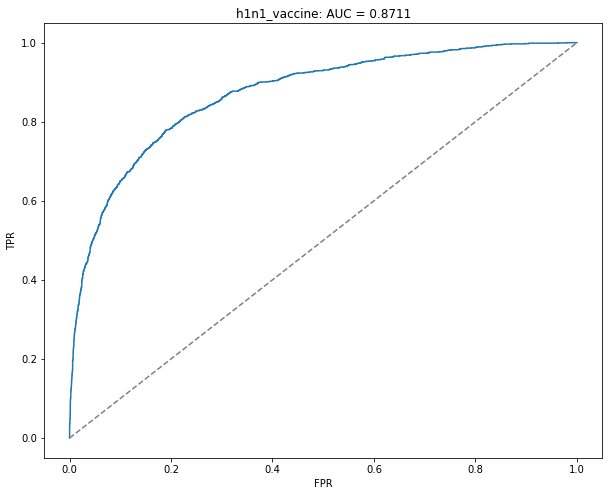

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y_test['h1n1_vaccine'], 
    predictions_h1, 
    'h1n1_vaccine',
    ax=ax
)

In [33]:
roc_auc_score(y_test.h1n1_vaccine, predictions_h1)

0.8710964730481472

## Second part

In [34]:
train_dataset_se = Pool(data=X_train,
                     label=y_train.seasonal_vaccine,
                     cat_features = categorical_features_indices)

I made a second objective function in case I'd want to change some tuning

In [35]:
def objective2(trial):
    param = {
        'iterations':trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
        'random_strength':trial.suggest_int("random_strength", 1,10),
        'bagging_temperature':trial.suggest_int("bagging_temperature", 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf':trial.suggest_int("min_data_in_leaf", 1,10),
        'od_type' : "Iter",
        'od_wait' : 100,
        "depth": trial.suggest_int("max_depth", 2,10),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
         'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        "loss_function": "Logloss",
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        }

    scores = cv(train_dataset_se,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=False, verbose=False) 

    return scores['test-AUC-mean'].max()

In [36]:
sampler = optuna.samplers.TPESampler(seed=68)  # Make the sampler behave in a deterministic way.
study2 = optuna.create_study(direction="maximize", sampler=sampler)
study2.optimize(objective2, n_trials=100)

[I 2021-02-17 01:58:46,608] A new study created in memory with name: no-name-03913ebf-5557-4268-9f2c-43f40117f5aa
[I 2021-02-17 01:59:12,754] Trial 0 finished with value: 0.8592774453063841 and parameters: {'iterations': 300, 'learning_rate': 0.013964954297408176, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 21.328495943450676, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8592774453063841.
[I 2021-02-17 01:59:26,032] Trial 1 finished with value: 0.8599969087296045 and parameters: {'iterations': 1200, 'learning_rate': 0.11477165079768124, 'random_strength': 9, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 7, 'l2_leaf_reg': 0.5714362138520529, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8599969087296045.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:00:01,309] Trial 2 finished with value: 0.861608374321975 and parameters: {'iterations': 1500, 'learning_rate': 0.06018181691194878, 'random_strength': 6, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 4, 'l2_leaf_reg': 7.937278880272323e-06, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.861608374321975.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:00:14,015] Trial 3 finished with value: 0.8586019282142363 and parameters: {'iterations': 100, 'learning_rate': 0.04917655399574397, 'random_strength': 1, 'bagging_temperature': 5, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 6, 'l2_leaf_reg': 1.253388039132331e-06, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.861608374321975.
[I 2021-02-17 02:00:27,447] Trial 4 finished with value: 0.8602753191026151 and parameters: {'iterations': 1500, 'learning_rate': 0.20567786125414012, 'random_strength': 8, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 2, 'l2_leaf_reg': 0.0011659140576640084, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.861608374321975.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:00:34,719] Trial 5 finished with value: 0.8567640003480698 and parameters: {'iterations': 100, 'learning_rate': 0.21103536986772822, 'random_strength': 4, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 4, 'l2_leaf_reg': 1.5248267732768012e-08, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.861608374321975.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:01:10,069] Trial 6 finished with value: 0.8617699180315392 and parameters: {'iterations': 1000, 'learning_rate': 0.039222305770230614, 'random_strength': 5, 'bagging_temperature': 3, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 4, 'l2_leaf_reg': 3.544948380552023e-06, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8617699180315392.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:01:44,172] Trial 7 finished with value: 0.860718479761989 and parameters: {'iterations': 1000, 'learning_rate': 0.045869610193466345, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 5, 'l2_leaf_reg': 6.629274905463984e-06, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8617699180315392.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:01:48,686] Trial 8 finished with value: 0.8518659419954195 and parameters: {'iterations': 1500, 'learning_rate': 0.2775338323862574, 'random_strength': 6, 'bagging_temperature': 4, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 9, 'l2_leaf_reg': 0.0010943835695463693, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 6 with value: 0.8617699180315392.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:01:52,676] Trial 9 finished with value: 0.8576354127969263 and parameters: {'iterations': 1000, 'learning_rate': 0.16527427195333977, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 5.547808519611033e-05, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 6 with value: 0.8617699180315392.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:02:11,155] Trial 10 finished with value: 0.8616278814855303 and parameters: {'iterations': 500, 'learning_rate': 0.11039932312091873, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 2, 'l2_leaf_reg': 1.2159249519874814e-08, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8617699180315392.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:02:30,680] Trial 11 finished with value: 0.8613644301746106 and parameters: {'iterations': 500, 'learning_rate': 0.1084207966325659, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 2, 'l2_leaf_reg': 1.2894289326228455e-08, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8617699180315392.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:02:55,635] Trial 12 finished with value: 0.8357434471221705 and parameters: {'iterations': 500, 'learning_rate': 0.004806416713353634, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 2, 'l2_leaf_reg': 6.39944753546505e-08, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8617699180315392.
[I 2021-02-17 02:03:11,141] Trial 13 finished with value: 0.8616457635070617 and parameters: {'iterations': 1000, 'learning_rate': 0.10411608463872443, 'random_strength': 3, 'bagging_temperature': 2, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 3, 'l2_leaf_reg': 1.276003870120915e-07, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8617699180315392.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:03:38,197] Trial 14 finished with value: 0.8619148959330752 and parameters: {'iterations': 1000, 'learning_rate': 0.07618156061546405, 'random_strength': 3, 'bagging_temperature': 2, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 3, 'l2_leaf_reg': 3.5865647557736247e-07, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 14 with value: 0.8619148959330752.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:03:50,054] Trial 15 finished with value: 0.8549497979408294 and parameters: {'iterations': 1000, 'learning_rate': 0.06969554503907559, 'random_strength': 7, 'bagging_temperature': 2, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 7, 'l2_leaf_reg': 0.0002906071529974482, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 14 with value: 0.8619148959330752.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:04:00,196] Trial 16 finished with value: 0.8609895930428383 and parameters: {'iterations': 200, 'learning_rate': 0.15325494851429844, 'random_strength': 2, 'bagging_temperature': 2, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 3, 'l2_leaf_reg': 6.938536064744217e-07, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 14 with value: 0.8619148959330752.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:05:03,898] Trial 17 finished with value: 0.8564992332206849 and parameters: {'iterations': 1000, 'learning_rate': 0.009317706201861467, 'random_strength': 5, 'bagging_temperature': 2, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 4, 'l2_leaf_reg': 0.04373352118950405, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 14 with value: 0.8619148959330752.
[I 2021-02-17 02:05:09,478] Trial 18 finished with value: 0.8367012309165419 and parameters: {'iterations': 1000, 'learning_rate': 0.07767821367355207, 'random_strength': 3, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 10, 'l2_leaf_reg': 2.5602616797376855e-05, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 14 with value: 0.8619148959330752.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:05:26,289] Trial 19 finished with value: 0.8498049035164978 and parameters: {'iterations': 300, 'learning_rate': 0.017984347045110226, 'random_strength': 5, 'bagging_temperature': 1, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 3, 'l2_leaf_reg': 1.2398896982274805e-06, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 14 with value: 0.8619148959330752.
[I 2021-02-17 02:06:08,776] Trial 20 finished with value: 0.8619727265448246 and parameters: {'iterations': 1200, 'learning_rate': 0.03236712628327796, 'random_strength': 7, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 6, 'l2_leaf_reg': 0.046219859585272895, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 20 with value: 0.8619727265448246.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:06:47,953] Trial 21 finished with value: 0.8597350906668979 and parameters: {'iterations': 1200, 'learning_rate': 0.03452823865248107, 'random_strength': 7, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 0.018537719843351754, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 20 with value: 0.8619727265448246.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:07:08,229] Trial 22 finished with value: 0.8583524447935437 and parameters: {'iterations': 1200, 'learning_rate': 0.08575309147911239, 'random_strength': 7, 'bagging_temperature': 3, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 8, 'l2_leaf_reg': 0.3397573285506683, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 20 with value: 0.8619727265448246.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:08:17,337] Trial 23 finished with value: 0.8624260361198551 and parameters: {'iterations': 1200, 'learning_rate': 0.027247202810574488, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 6, 'l2_leaf_reg': 39.55970394954269, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 23 with value: 0.8624260361198551.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:08:31,360] Trial 24 finished with value: 0.8609916595255 and parameters: {'iterations': 1200, 'learning_rate': 0.13650969502800792, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 6, 'l2_leaf_reg': 14.889821880428762, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 23 with value: 0.8624260361198551.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:10:14,239] Trial 25 finished with value: 0.861997483772733 and parameters: {'iterations': 1200, 'learning_rate': 0.02712686924609191, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 8, 'l2_leaf_reg': 88.84655832391311, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 23 with value: 0.8624260361198551.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:11:59,242] Trial 26 finished with value: 0.8622215414530657 and parameters: {'iterations': 1200, 'learning_rate': 0.027279570694869436, 'random_strength': 10, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 8, 'l2_leaf_reg': 95.65012826306524, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 23 with value: 0.8624260361198551.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:12:09,964] Trial 27 finished with value: 0.8582590962360153 and parameters: {'iterations': 1200, 'learning_rate': 0.29935905333625645, 'random_strength': 10, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 9, 'l2_leaf_reg': 88.42202477486413, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 23 with value: 0.8624260361198551.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:14:34,841] Trial 28 finished with value: 0.8448933869047659 and parameters: {'iterations': 1200, 'learning_rate': 0.0012883179018759842, 'random_strength': 9, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 8, 'l2_leaf_reg': 4.507225065456655, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 23 with value: 0.8624260361198551.
[I 2021-02-17 02:15:00,735] Trial 29 finished with value: 0.8511466699775211 and parameters: {'iterations': 200, 'learning_rate': 0.018121978525421818, 'random_strength': 10, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 8, 'l2_leaf_reg': 82.80146360137286, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 23 with value: 0.8624260361198551.
[I 2021-02-17 02:16:10,806] Trial 30 finished with value: 0.8606369200848867 and parameters: {'iterations': 1200, 'learning_rate': 0.0253437097159

Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:16:51,352] Trial 31 finished with value: 0.8624760408843091 and parameters: {'iterations': 1200, 'learning_rate': 0.05571026924312778, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 6, 'l2_leaf_reg': 92.84631319598631, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:18:56,698] Trial 32 finished with value: 0.8422039202853909 and parameters: {'iterations': 1200, 'learning_rate': 0.0010313180718820245, 'random_strength': 9, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 7, 'l2_leaf_reg': 24.67310566534338, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.
[I 2021-02-17 02:19:31,048] Trial 33 finished with value: 0.859487821029903 and parameters: {'iterations': 1200, 'learning_rate': 0.062100494868209254, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 9, 'l2_leaf_reg': 1.2952184669897353, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:20:06,984] Trial 34 finished with value: 0.8617578410670788 and parameters: {'iterations': 300, 'learning_rate': 0.052470154488746826, 'random_strength': 9, 'bagging_temperature': 7, 'max_bin': 30, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 8, 'l2_leaf_reg': 45.787192748037945, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.
[I 2021-02-17 02:20:19,957] Trial 35 finished with value: 0.8616715967736706 and parameters: {'iterations': 1200, 'learning_rate': 0.09350163378814949, 'random_strength': 8, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 8.394192250872125, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:20:57,820] Trial 36 finished with value: 0.8611326533509001 and parameters: {'iterations': 1200, 'learning_rate': 0.051467883369440526, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 7, 'l2_leaf_reg': 1.2592120964345, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:21:04,326] Trial 37 finished with value: 0.8448587047236252 and parameters: {'iterations': 100, 'learning_rate': 0.02568221228798362, 'random_strength': 8, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 87.48517216184811, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 31 with value: 0.8624760408843091.
[I 2021-02-17 02:21:20,064] Trial 38 finished with value: 0.853128473568199 and parameters: {'iterations': 1200, 'learning_rate': 0.12773638178556146, 'random_strength': 9, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 9, 'l2_leaf_reg': 0.22026399083527087, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:21:29,547] Trial 39 finished with value: 0.860400768400553 and parameters: {'iterations': 1200, 'learning_rate': 0.18799555523262435, 'random_strength': 10, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 22.52332464723313, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:22:06,265] Trial 40 finished with value: 0.861516799464793 and parameters: {'iterations': 1500, 'learning_rate': 0.042578219791789336, 'random_strength': 9, 'bagging_temperature': 4, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 7, 'l2_leaf_reg': 2.087481458571183, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:22:50,192] Trial 41 finished with value: 0.8609410005750432 and parameters: {'iterations': 1200, 'learning_rate': 0.030632757759002652, 'random_strength': 10, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 0.010120344084021772, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:23:14,283] Trial 42 finished with value: 0.8610182421679324 and parameters: {'iterations': 1200, 'learning_rate': 0.06461226321948788, 'random_strength': 8, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 6, 'l2_leaf_reg': 0.054234637196588546, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:24:20,167] Trial 43 finished with value: 0.8628189010522164 and parameters: {'iterations': 1200, 'learning_rate': 0.04020226312212685, 'random_strength': 9, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 7, 'l2_leaf_reg': 90.13854739728647, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:24:28,825] Trial 44 finished with value: 0.8535210908812981 and parameters: {'iterations': 100, 'learning_rate': 0.04924979597860921, 'random_strength': 9, 'bagging_temperature': 4, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 8, 'l2_leaf_reg': 40.94570190854328, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.
[I 2021-02-17 02:26:30,637] Trial 45 finished with value: 0.8592894008103542 and parameters: {'iterations': 1200, 'learning_rate': 0.009427441664574057, 'random_strength': 10, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 7, 'l2_leaf_reg': 10.287509791866576, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.
[I 2021-02-17 02:26:39,562] Trial 46 finished with value: 0.8602585888878375 and parameters: {'iterations': 1200, 'learning_rate': 0.2533464487929

Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:27:05,906] Trial 47 finished with value: 0.8614314481756443 and parameters: {'iterations': 1500, 'learning_rate': 0.09233047273917006, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 8, 'l2_leaf_reg': 95.2433470499676, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:27:42,278] Trial 48 finished with value: 0.8620117436511997 and parameters: {'iterations': 500, 'learning_rate': 0.05910864313515036, 'random_strength': 10, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 7, 'l2_leaf_reg': 4.8256119684481265, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:28:13,440] Trial 49 finished with value: 0.8620452402442842 and parameters: {'iterations': 500, 'learning_rate': 0.056721079608529255, 'random_strength': 9, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 6, 'l2_leaf_reg': 5.3512189414574705, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:28:50,569] Trial 50 finished with value: 0.8622923239683138 and parameters: {'iterations': 500, 'learning_rate': 0.04192853723185702, 'random_strength': 8, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 0.6513400670834688, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:29:09,173] Trial 51 finished with value: 0.8568569561359218 and parameters: {'iterations': 200, 'learning_rate': 0.04160025060921315, 'random_strength': 8, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 0.7555161140528094, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.
[I 2021-02-17 02:29:37,594] Trial 52 finished with value: 0.8621902474273602 and parameters: {'iterations': 500, 'learning_rate': 0.07329192392784331, 'random_strength': 9, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 4, 'l2_leaf_reg': 14.58670726905145, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:30:02,870] Trial 53 finished with value: 0.8624964492575723 and parameters: {'iterations': 500, 'learning_rate': 0.07253083471785571, 'random_strength': 6, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 4, 'l2_leaf_reg': 22.98843930329072, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:30:43,400] Trial 54 finished with value: 0.8576171145804865 and parameters: {'iterations': 500, 'learning_rate': 0.017936089217252614, 'random_strength': 6, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 4, 'l2_leaf_reg': 31.27361535509004, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.
[I 2021-02-17 02:31:04,463] Trial 55 finished with value: 0.8623314647519738 and parameters: {'iterations': 500, 'learning_rate': 0.08222021943922227, 'random_strength': 6, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 4, 'l2_leaf_reg': 2.5013696924716973, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:31:18,140] Trial 56 finished with value: 0.8610512242661583 and parameters: {'iterations': 500, 'learning_rate': 0.11412893766081442, 'random_strength': 6, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 0.15433506787685775, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:31:36,692] Trial 57 finished with value: 0.8613923673116105 and parameters: {'iterations': 500, 'learning_rate': 0.085141915740434, 'random_strength': 7, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 2.5141006580046037, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:31:52,378] Trial 58 finished with value: 0.8612630878227835 and parameters: {'iterations': 500, 'learning_rate': 0.09589713030939544, 'random_strength': 6, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 4, 'l2_leaf_reg': 0.43878407336956, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:32:07,086] Trial 59 finished with value: 0.8615545933637773 and parameters: {'iterations': 500, 'learning_rate': 0.12723347031619192, 'random_strength': 5, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 3, 'l2_leaf_reg': 15.782010297515773, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:32:24,763] Trial 60 finished with value: 0.8603807833688792 and parameters: {'iterations': 500, 'learning_rate': 0.06767390848361435, 'random_strength': 6, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 0.0038331250495747165, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:32:48,765] Trial 61 finished with value: 0.8593328958417565 and parameters: {'iterations': 300, 'learning_rate': 0.04002795336574851, 'random_strength': 7, 'bagging_temperature': 6, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 4, 'l2_leaf_reg': 34.160901732588805, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.
[I 2021-02-17 02:33:12,403] Trial 62 finished with value: 0.8612478466653123 and parameters: {'iterations': 500, 'learning_rate': 0.08298667194068889, 'random_strength': 8, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 8.990875597184502, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:33:58,208] Trial 63 finished with value: 0.8629142688449043 and parameters: {'iterations': 500, 'learning_rate': 0.03491751310099027, 'random_strength': 5, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 1.8211023402465396, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:34:31,979] Trial 64 finished with value: 0.8623054972865773 and parameters: {'iterations': 500, 'learning_rate': 0.04107559164106448, 'random_strength': 4, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 0.7995434990095341, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:34:54,473] Trial 65 finished with value: 0.8625410372679563 and parameters: {'iterations': 500, 'learning_rate': 0.07106096822317107, 'random_strength': 4, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 2.273919878847142, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:35:12,578] Trial 66 finished with value: 0.8619768911739152 and parameters: {'iterations': 500, 'learning_rate': 0.07435748178285664, 'random_strength': 3, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 3, 'l2_leaf_reg': 2.341213045555641, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:35:27,906] Trial 67 finished with value: 0.8613733031099311 and parameters: {'iterations': 500, 'learning_rate': 0.10061698498467272, 'random_strength': 4, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 6, 'l2_leaf_reg': 0.10944962662679808, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:35:51,483] Trial 68 finished with value: 0.8613503283172014 and parameters: {'iterations': 500, 'learning_rate': 0.05331669990575415, 'random_strength': 5, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 0.00018285984431075052, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:35:59,589] Trial 69 finished with value: 0.8566885276248998 and parameters: {'iterations': 100, 'learning_rate': 0.0641831119378872, 'random_strength': 5, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 6.043144943879615, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:36:50,508] Trial 70 finished with value: 0.8604960386211935 and parameters: {'iterations': 500, 'learning_rate': 0.013594721532242872, 'random_strength': 2, 'bagging_temperature': 4, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 1.77312277797755, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:37:41,634] Trial 71 finished with value: 0.862710225312353 and parameters: {'iterations': 500, 'learning_rate': 0.0350151166318715, 'random_

Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:38:21,519] Trial 72 finished with value: 0.8627817365905435 and parameters: {'iterations': 500, 'learning_rate': 0.035001908536129056, 'random_strength': 4, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 4, 'l2_leaf_reg': 3.13127627723157, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:38:40,970] Trial 73 finished with value: 0.8567171783050588 and parameters: {'iterations': 200, 'learning_rate': 0.021780985189808935, 'random_strength': 3, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 16.13766517425775, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:39:20,994] Trial 74 finished with value: 0.8625779304204432 and parameters: {'iterations': 500, 'learning_rate': 0.03326560521656461, 'ran

Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:41:35,123] Trial 78 finished with value: 0.861661843671647 and parameters: {'iterations': 500, 'learning_rate': 0.03262756198451842, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 3, 'l2_leaf_reg': 0.447397179748981, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:42:05,616] Trial 79 finished with value: 0.8624566134591856 and parameters: {'iterations': 500, 'learning_rate': 0.0452970152697529, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 0.023319854557215667, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:42:44,809] Trial 80 finished with value: 0.8540335533364083 and parameters: {'iterations': 500, 'learning_rate': 0.010032703148291439, 'random_strength': 5, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 1.027664406808666, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:43:19,053] Trial 81 finished with value: 0.8629017607304437 and parameters: {'iterations': 500, 'learning_rate': 0.0494773083884324, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 4, 'l2_leaf_reg': 3.3307922351471193, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:43:50,426] Trial 82 finished with value: 0.8624013913198265 and parameters: {'iterations': 500, 'learning_rate': 0.049542492974861296, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 3, 'l2_leaf_reg': 0.20418092319233863, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:44:13,826] Trial 83 finished with value: 0.8619764751113526 and parameters: {'iterations': 500, 'learning_rate': 0.06873506936751295, 'random_strength': 5, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 4, 'l2_leaf_reg': 3.5171984820667594, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:44:53,678] Trial 84 finished with value: 0.8627432322254434 and parameters: {'iterations': 500, 'learning_rate': 0.03421553291010362, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 1.279551978103478, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:45:36,135] Trial 85 finished with value: 0.8625860809785129 and parameters: {'iterations': 500, 'learning_rate': 0.033269810078548415, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 5, 'l2_leaf_reg': 0.10983660655047413, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:46:15,406] Trial 86 finished with value: 0.8626428835931395 and parameters: {'iterations': 1500, 'learning_rate': 0.03404153880322145, 'random_strength': 3, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 0.11690785082262126, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:47:08,187] Trial 87 finished with value: 0.8626456622293277 and parameters: {'iterations': 1500, 'learning_rate': 0.020650041705929434, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 0.027931864894058415, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:48:24,535] Trial 88 finished with value: 0.8626965497081441 and parameters: {'iterations': 1500, 'learning_rate': 0.014966381186391205, 'random_strength': 2, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.02907660759142206, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:50:30,038] Trial 89 finished with value: 0.8510351179301624 and parameters: {'iterations': 1500, 'learning_rate': 0.0013992145042054163, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.012752600162201205, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:51:20,823] Trial 90 finished with value: 0.862443623043017 and parameters: {'iterations': 1500, 'learning_rate': 0.020255318965288774, 'random_strength': 2, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 0.0032786412356445942, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:52:32,738] Trial 91 finished with value: 0.8627868022639097 and parameters: {'iterations': 1500, 'learning_rate': 0.016208026164651508, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 0.03229965403267229, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:53:40,379] Trial 92 finished with value: 0.8623905719396159 and parameters: {'iterations': 1500, 'learning_rate': 0.016219596687074282, 'random_strength': 3, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 0.020324000210090877, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:54:17,055] Trial 93 finished with value: 0.8623952786907809 and parameters: {'iterations': 1500, 'learning_rate': 0.024683334828658334, 'random_strength': 1, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.005206609735610267, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:55:59,178] Trial 94 finished with value: 0.8601159023908957 and parameters: {'iterations': 1500, 'learning_rate': 0.006850829104537047, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 4, 'l2_leaf_reg': 0.037270252908201226, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:57:17,634] Trial 95 finished with value: 0.863132450431481 and parameters: {'iterations': 1500, 'learning_rate': 0.015393853845985255, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.03977425239611938, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 95 with value: 0.863132450431481.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:58:40,984] Trial 96 finished with value: 0.8626726388656365 and parameters: {'iterations': 1500, 'learning_rate': 0.012469721707158859, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.0005650382037853742, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 95 with value: 0.863132450431481.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:59:33,794] Trial 97 finished with value: 0.8622695225487712 and parameters: {'iterations': 1500, 'learning_rate': 0.014165527219236959, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.00020647121997590114, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 95 with value: 0.863132450431481.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 03:00:14,194] Trial 98 finished with value: 0.8616028724032899 and parameters: {'iterations': 1500, 'learning_rate': 0.02661898255265924, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 6, 'l2_leaf_reg': 0.0005062657170811357, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 95 with value: 0.863132450431481.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 03:02:18,705] Trial 99 finished with value: 0.8587725661746266 and parameters: {'iterations': 1500, 'learning_rate': 0.0033222800504134065, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.0014617936344147216, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 95 with value: 0.863132450431481.


In [37]:
print("Number of finished trials: {}".format(len(study2.trials)))
print("Best trial:")
trial2 = study2.best_trial
print("  Value: {}".format(trial2.value))
print("  Params: ")
for key, value in trial2.params.items():
    print("    {}={},".format(key, value))


Number of finished trials: 100
Best trial:
  Value: 0.863132450431481
  Params: 
    iterations=1500,
    learning_rate=0.015393853845985255,
    random_strength=3,
    bagging_temperature=7,
    max_bin=8,
    grow_policy=Lossguide,
    min_data_in_leaf=1,
    max_depth=5,
    l2_leaf_reg=0.03977425239611938,
    one_hot_max_size=500,
    auto_class_weights=Balanced,


In [38]:
final_model_se = CatBoostClassifier(verbose=False,  cat_features=categorical_features_indices, 
                                    **trial2.params)

In [39]:
final_model_se.fit(X_train, y_train.seasonal_vaccine)

In [40]:
predictions_se = final_model_se.predict_proba(X_test)

In [41]:
predictions_se = predictions_se[:,1].reshape(-1,1)

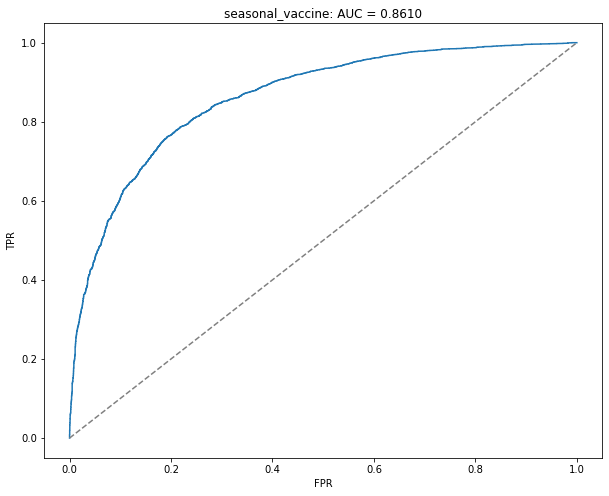

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y_test['seasonal_vaccine'], 
    predictions_se, 
    'seasonal_vaccine',
    ax=ax
)

In [43]:
roc_auc_score(y_test.seasonal_vaccine, predictions_se)

0.8610242609729017

## Combined score

In [44]:
# Let's see the score combined of the two best predictions
roc_auc_score(y_test, np.hstack((predictions_h1, predictions_se)))

0.8660603670105245

## Retrain on full dataset

#### Seasonal

In [45]:
final_model_se.fit(train, labels.seasonal_vaccine)

In [47]:
final_se = final_model_se.predict_proba(test)

In [48]:
final_se = final_se[:,1].reshape(-1,1)

#### H1N1

In [50]:
final_model.fit(train, labels.h1n1_vaccine)

In [51]:
final_h1 = final_model.predict_proba(test)

In [52]:
final_h1 = final_h1[:,1].reshape(-1,1)

## Make submission

In [53]:
submission_df = pd.read_csv("./submission_format.csv", 
                            index_col="respondent_id")

In [54]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["h1n1_vaccine"] = final_h1
submission_df["seasonal_vaccine"] = final_se

submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.370448,0.273193
26708,0.079469,0.044629
26709,0.504887,0.735957
26710,0.879725,0.891950
26711,0.687898,0.509354


In [55]:
date = pd.Timestamp.now().strftime(format='%Y-%m-%d_%H-%M_')
submission_df.to_csv(f'predictions/{date}submssion_catboost_optunacvi.csv', index=True)

The model scored `0.8608` not too bad, much better than the benchmark. There is a lot of room for improvment (my present score is `0.8638`, ranking **7th** on the 16th February 2021). We can verify some more parameters, CatBoost has a lot of [them](https://catboost.ai/docs/concepts/parameter-tuning.html), we may try some feature engineering (I tried some basice ones but the score did not improve so I omitted them in the analysis), change the model (LightGBM, XGBoost for example), try different imputations, increase the rounds for `optuna` a little bit and so on. Spend some time analysing the dataset and the correlation among the variables using EDA notebooks.